# Control of a "spacecraft" platform with a reaction wheel

In [1]:
# These are standard modules
import time
import numpy as np
from scipy import linalg
import sympy as sym
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Markdown

# This is a custom interface to the pybullet simulator
import ae353_platform

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Given a choice of ground roll angle $\phi$, the equations of motion are

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

where

* $q_1$ is the platform angle
* $\dot{q}_1$ is the platform velocity
* $v_2$ is the wheel velocity
* $\tau$ is the torque applied *to* the platform *by* the wheel

and

$$
J_1 = J_p + m_wl^2
\qquad
\qquad
J_2 = J_w
$$

and parameter values are defined as follows:

In [2]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

Create an instance of the simulator (do `Kernel -> Restart` before evaluating this cell).

In [3]:
simulator = ae353_platform.Simulator(
    display=False,
    roll=0.,
)

# Control wheel velocity only (no gravity)

Set ground roll angle of simulator.

In [4]:
simulator.set_roll(0.)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$, ignore platform) are:

$$
\begin{aligned}
J_1 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define functions to do all the analysis.

In [5]:
# Define a function to return a state-space model for a given choice of equilibrium point.
def get_model(v2e, taue):
    # Define variables
    v2, tau = sym.symbols('v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        - ((J1 + J2) / (J1 * J2)) * tau,
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([v2, tau], f)
    if not np.allclose(f_num(v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([v2])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([v2, tau], A_sym)
    B_num = sym.lambdify([v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(v2e, taue).astype(float)
    B = B_num(v2e, taue).astype(float)

    # Return A and B
    return A, B

# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, v2e, taue):
        self.K = K
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, v2e, taue, K, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, v2e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=0.,
        platform_velocity=0.,
        wheel_angle=0.,
        wheel_velocity=v2i,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['wheel_velocity'][0] - v2e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x

# Define a function to find symbolic solution to closed-loop (linear) system.
def get_x_symbolic(A, B, K):
    # Model
    A = sym.nsimplify(sym.Matrix(A), rational=True)
    B = sym.nsimplify(sym.Matrix(B), rational=True)
    K = sym.nsimplify(sym.Matrix(K), rational=True)
    
    # Variables
    t, x_1i = sym.symbols('t, x_1i', real=True)
    
    # Initial condition
    x0 = sym.Matrix([x_1i])
    
    # Solution
    x = sym.exp((A - B @ K) * t) @ x0
    return x

# Define a function to show symbolic solution to closed-loop (linear) system.
def show_x_symbolic(A, B, K):
    x = get_x_symbolic(A, B, K)
    print('\nSOLUTION TO CLOSED-LOOP SYSTEM')
    display(Markdown(f'$$x(t) = {sym.latex(x)}$$'))
    
# Define a function to show results.
def show_results(data, v2e, taue, A, B, K, v2i, show_pred=False):
    t = data['t']
    v2 = data['wheel_velocity']
    x1 = v2 - v2e
    
    fig, (ax_v2, ax_x1) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

    ax_v2.plot(t, v2, label='$v_2$', linewidth=4)
    ax_v2.plot(t, np.ones_like(t) * v2e, '--', label='$v_2$ (desired)', linewidth=4)
    
    ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
    ax_x1.plot(t, np.zeros_like(t), '--', label='$x_1$ (desired)', linewidth=4)
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, v2e, A, B)
        x1_num = x_num[:, 0]
        
        # Compute v2(t) from x(t)
        v2_num = x1_num + v2e
        
        # Add everything to plots
        ax_v2.plot(t, v2_num, ':', label='$v_2$ (linear)', linewidth=6, color='C3')
        ax_x1.plot(t, x1_num, ':', label='$x_1$ (linear)', linewidth=6, color='C3')
        
    ax_v2.grid()
    ax_v2.legend(fontsize=16)
    ax_v2.tick_params(labelsize=14)
    ax_v2.set_ylim(-2*np.pi, 4*np.pi)
    
    ax_x1.grid()
    ax_x1.legend(fontsize=16)
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-3*np.pi, 3*np.pi)
        
    ax_v2.set_xlabel('time (s)', fontsize=20)
    ax_v2.set_xlim([data['t'][0], data['t'][-1]])
    ax_x1.set_xlabel('time (s)', fontsize=20)
    ax_x1.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

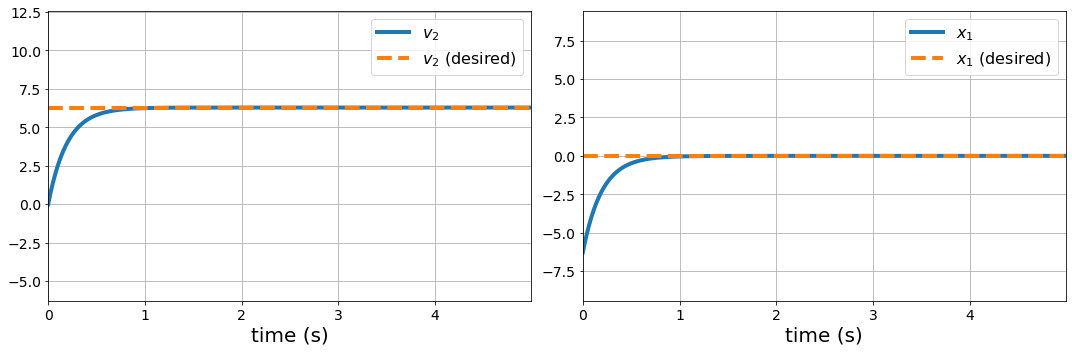

In [6]:
(v2e, taue) = (2*np.pi, 0.) # <-- EQUILIBRIUM POINT
K = np.array([[-5./33.]]) # <-- GAIN MATRIX FOR LINEAR STATE FEEDBACK
(v2i) = (0.) # <-- INITIAL CONDITIONS

A, B = get_model(v2e, taue)
data = get_data(simulator, v2e, taue, K, v2i, max_time=5.0)
show_results(data, v2e, taue, A, B, K, v2i, show_pred=False)
# show_x_symbolic(A, B, K)
# print('\nEIGENVALUES OF CLOSED-LOOP SYSTEM\n')
# print(f's = {linalg.eigvals(A - B @ K)}')

# Control platform angle only (no gravity)

Set ground roll angle of simulator.

In [7]:
simulator.set_roll(0.)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=0$, ignore wheel) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define functions to do all the analysis.

In [8]:
# Define a function to return a state-space model for a given choice of equilibrium point.
def get_model(q1e, v1e, taue):
    # Define variables
    q1, v1, tau = sym.symbols('q1, v1, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * tau,
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, tau], f)
    if not np.allclose(f_num(q1e, v1e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, tau], A_sym)
    B_num = sym.lambdify([q1, v1, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, taue).astype(float)
    B = B_num(q1e, v1e, taue).astype(float)

    # Return A and B
    return A, B

# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, q1e, v1e, taue, K, q1i, v1i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=q1i,
        platform_velocity=v1i,
        wheel_angle=0.,
        wheel_velocity=0.,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, q1e, v1e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x

# Define a function to find symbolic solution to closed-loop (linear) system.
def get_x_symbolic(A, B, K):
    # Model
    A = sym.nsimplify(sym.Matrix(A), rational=True)
    B = sym.nsimplify(sym.Matrix(B), rational=True)
    K = sym.nsimplify(sym.Matrix(K), rational=True)
    
    # Variables
    t, x_1i, x_2i = sym.symbols('t, x_1i, x_2i', real=True)
    
    # Initial condition
    x0 = sym.Matrix([x_1i, x_2i])
    
    # Solution
    x = sym.exp((A - B @ K) * t) @ x0
    return x

# Define a function to show symbolic solution to closed-loop (linear) system.
def show_x_symbolic(A, B, K):
    x = get_x_symbolic(A, B, K)
    print('\nSOLUTION TO CLOSED-LOOP SYSTEM')
    display(Markdown(f'$$x(t) = {sym.latex(x)}$$'))
    
# Define a function to show results.
def show_results(data, q1e, v1e, taue, A, B, K, q1i, v1i, show_pred=False):
    t = data['t']
    q1 = data['platform_angle']
    v1 = data['platform_velocity']
    x1 = q1 - q1e
    x2 = v1 - v1e
    
    fig, ((ax_q1, ax_x1), (ax_v1, ax_x2)) = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

    ax_q1.plot(t, q1, label='$q_1$', linewidth=4)
    ax_q1.plot(t, np.ones_like(t) * q1e, '--', label='$q_1$ (desired)', linewidth=4)
    
    ax_v1.plot(t, v1, label='$v_1$', linewidth=4)
    ax_v1.plot(t, np.ones_like(t) * v1e, '--', label='$v_1$ (desired)', linewidth=4)
    
    ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
    ax_x1.plot(t, np.zeros_like(t), '--', label='$x_1$ (desired)', linewidth=4)
    
    ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
    ax_x2.plot(t, np.zeros_like(t), '--', label='$x_2$ (desired)', linewidth=4)
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, q1e, v1e, A, B)
        x1_num = x_num[:, 0]
        x2_num = x_num[:, 1]
        
        # Compute q1(t) and v1(t) from x(t)
        q1_num = x1_num + q1e
        v1_num = x2_num + v1e
        
        # Add everything to plots
        ax_q1.plot(t, q1_num, ':', label='$q_1$ (linear)', linewidth=6, color='C3')
        ax_v1.plot(t, v1_num, ':', label='$v_1$ (linear)', linewidth=6, color='C3')
        ax_x1.plot(t, x1_num, ':', label='$x_1$ (linear)', linewidth=6, color='C3')
        ax_x2.plot(t, x2_num, ':', label='$x_2$ (linear)', linewidth=6, color='C3')
        
    ax_q1.grid()
    ax_q1.legend(fontsize=16)
    ax_q1.tick_params(labelsize=14)
    ax_q1.set_ylim(-1, 1)
    
    ax_v1.grid()
    ax_v1.legend(fontsize=16)
    ax_v1.tick_params(labelsize=14)
    ax_v1.set_ylim(-1, 1)

    ax_x1.grid()
    ax_x1.legend(fontsize=16)
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-1, 1)
        
    ax_x2.grid()
    ax_x2.legend(fontsize=16)
    ax_x2.tick_params(labelsize=14)
    ax_x2.set_ylim(-1, 1)
    
    ax_v1.set_xlabel('time (s)', fontsize=20)
    ax_v1.set_xlim([data['t'][0], data['t'][-1]])
    ax_x2.set_xlabel('time (s)', fontsize=20)
    ax_x2.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

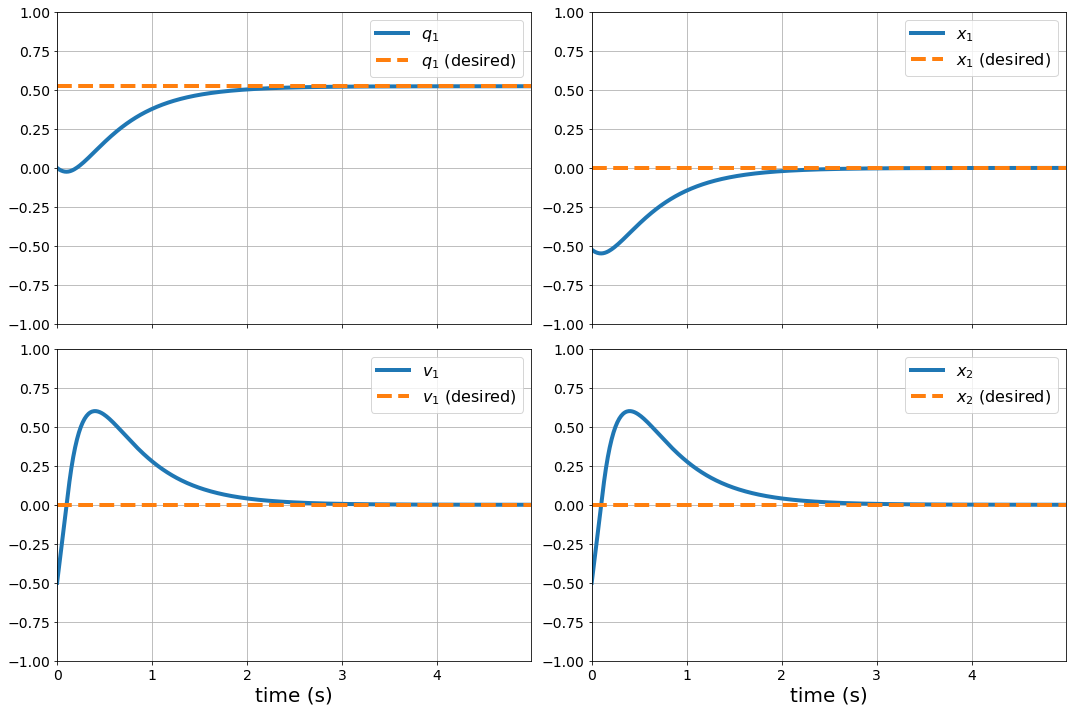

s = [-2.+0.j -5.+0.j]


In [9]:
(q1e, v1e, taue) = (np.pi / 6, 0., 0.) # <-- EQUILIBRIUM POINT
K = np.array([[10., 7.]]) # <-- GAIN MATRIX FOR LINEAR STATE FEEDBACK
# K = np.array([[-6., 1.]]) # <-- GAIN MATRIX FOR LINEAR STATE FEEDBACK
# K = np.array([[5., 2.]]) # <-- GAIN MATRIX FOR LINEAR STATE FEEDBACK
# K = np.array([[4., 4.]]) # <-- GAIN MATRIX FOR LINEAR STATE FEEDBACK


(q1i, v1i) = (0., -0.5) # <-- INITIAL CONDITIONS

A, B = get_model(q1e, v1e, taue)
data = get_data(simulator, q1e, v1e, taue, K, q1i, v1i, max_time=5.0)
show_results(data, q1e, v1e, taue, A, B, K, q1i, v1i, show_pred=False)
# show_x_symbolic(A, B, K)
# print('\nEIGENVALUES OF CLOSED-LOOP SYSTEM\n')
print(f's = {linalg.eigvals(A - B @ K)}')

Find closed-loop system:

$$F = A - BK$$

In [10]:
F = A - B @ K
print('F =')
print(F)

F =
[[  0.   1.]
 [-10.  -7.]]


Find eigenvalues of closed-loop system:

In [11]:
s = linalg.eigvals(F)
print(f's = {s}')

s = [-2.+0.j -5.+0.j]


Find:

* a matrix $S$ with eigenvalues in each diagonal entry
* a matrix $V$ with the corresponding eigenvectors in each column

In [12]:
s, V = linalg.eig(F)
S = np.diag(s)
print('S =')
print(S)
print('\nV =')
print(V)

S =
[[-2.+0.j  0.+0.j]
 [ 0.+0.j -5.+0.j]]

V =
[[ 0.4472136  -0.19611614]
 [-0.89442719  0.98058068]]


Notice that the columns of $V$ (i.e., the eigenvectors of $F$) are normalized:

In [13]:
print(f'length of v1 = {linalg.norm(V[:, 0]):g}')
print(f'length of v2 = {linalg.norm(V[:, 1]):g}')

length of v1 = 1
length of v2 = 1


Show that:

$$V^{-1}FV = S = \text{diag}(s_1, s_2)$$

In [14]:
print(linalg.inv(V) @ F @ V)

[[-2. -0.]
 [ 0. -5.]]


Show that:

$$e^{Ft}x_0 = V e^{V^{-1}FVt}V^{-1}x_0$$

In [15]:
# Choose a time and an initial condition for this example
t = 0.1
x0 = np.array([[1.], [-2.]])

# Compute solution the normal way
print('solution:')
print(linalg.expm(F * t) @ x0)

# Compute solution by diagonalization
print('\nsolution by diagonalization:')
print(V @ linalg.expm(linalg.inv(V) @ F @ V * t) @ linalg.inv(V) @ x0)
# print('\nsolution by diagonalization (real part only):')
# print((V @ linalg.expm(linalg.inv(V) @ F @ V * t) @ linalg.inv(V) @ x0).real)

solution:
[[ 0.81873075]
 [-1.63746151]]

solution by diagonalization:
[[ 0.81873075]
 [-1.63746151]]


Find solution at arbitrary time for arbitrary initial condition:

$$ x(t) = e^{Ft} x(0) $$

In [16]:
# Symbolic variables
t, x_1i, x_2i = sym.symbols('t, x_1i, x_2i', real=True)

# Closed-loop system (symbolic)
F = sym.nsimplify(sym.Matrix(F), rational=True)

# Initial condition (symbolic)
x0 = sym.Matrix([x_1i, x_2i])

# Solution (symbolic)
x = sym.exp(F * t) @ x0
# sym.simplify(sym.exp(F * t) @ x0)
# sym.simplify(sym.exp(F * t) @ x0).expand()

# Display
display(Markdown(f'$$x(t) = {sym.latex(x)}$$'))

$$x(t) = \left[\begin{matrix}x_{1i} \left(\frac{5 e^{- 2 t}}{3} - \frac{2 e^{- 5 t}}{3}\right) + x_{2i} \left(\frac{e^{- 2 t}}{3} - \frac{e^{- 5 t}}{3}\right)\\x_{1i} \left(- \frac{10 e^{- 2 t}}{3} + \frac{10 e^{- 5 t}}{3}\right) + x_{2i} \left(- \frac{2 e^{- 2 t}}{3} + \frac{5 e^{- 5 t}}{3}\right)\end{matrix}\right]$$

Diagonalize $F$ again, this time with symbolic computation:

In [17]:
V, S = F.diagonalize()

display(Markdown(f'$$V = {sym.latex(V)}$$'))
display(Markdown(f'$$S = {sym.latex(S)}$$'))

$$V = \left[\begin{matrix}-1 & -1\\5 & 2\end{matrix}\right]$$

$$S = \left[\begin{matrix}-5 & 0\\0 & -2\end{matrix}\right]$$

Are the eigenvalues and eigenvectors the same as we got before?

In [18]:
# Normalize each eigenvector
v1 = V[:, 0] / V[:, 0].norm()
v2 = V[:, 1] / V[:, 1].norm()

# Convert each eigenvector from symbolic to numeric
v1 = np.array(v1.evalf()).astype(complex)
v2 = np.array(v2.evalf()).astype(complex)

# Show each eigenvector
print(f'v1 =\n{v1}\n')
print(f'v2 =\n{v2}')

v1 =
[[-0.19611614+0.j]
 [ 0.98058068+0.j]]

v2 =
[[-0.4472136 +0.j]
 [ 0.89442719+0.j]]


Find solution at arbitrary time for arbitrary initial condition by diagonalization:

$$x(t) = Ve^{V^{-1}FVt}V^{-1}x(0) = Ve^{St}V^{-1}x(0)$$

In [19]:
# Solution (symbolic, by diagonalization)
x_diag = V @ sym.exp(S * t) @ V.inv() @ x0

# # Simplify solution (expanding all complex exponentials)
# x_diag = sym.expand_complex(x_diag)
# x_diag = sym.simplify(x_diag, full=True)

# Display
print('SOLUTION')
display(Markdown(f'$$x(t) = {sym.latex(x)}$$'))
print('\nSOLUTION BY DIAGONALIZATION')
display(Markdown(f'$$x(t) = {sym.latex(x_diag)}$$'))

SOLUTION


$$x(t) = \left[\begin{matrix}x_{1i} \left(\frac{5 e^{- 2 t}}{3} - \frac{2 e^{- 5 t}}{3}\right) + x_{2i} \left(\frac{e^{- 2 t}}{3} - \frac{e^{- 5 t}}{3}\right)\\x_{1i} \left(- \frac{10 e^{- 2 t}}{3} + \frac{10 e^{- 5 t}}{3}\right) + x_{2i} \left(- \frac{2 e^{- 2 t}}{3} + \frac{5 e^{- 5 t}}{3}\right)\end{matrix}\right]$$


SOLUTION BY DIAGONALIZATION


$$x(t) = \left[\begin{matrix}x_{1i} \left(\frac{5 e^{- 2 t}}{3} - \frac{2 e^{- 5 t}}{3}\right) + x_{2i} \left(\frac{e^{- 2 t}}{3} - \frac{e^{- 5 t}}{3}\right)\\x_{1i} \left(- \frac{10 e^{- 2 t}}{3} + \frac{10 e^{- 5 t}}{3}\right) + x_{2i} \left(- \frac{2 e^{- 2 t}}{3} + \frac{5 e^{- 5 t}}{3}\right)\end{matrix}\right]$$

# Control platform angle and wheel velocity with gravity

Set ground roll angle of simulator.

In [20]:
simulator.set_roll(np.pi / 2)

The full equations of motion are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

The equations of motion in this particular case ($\phi=\pi/2$) are:

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1) \\
J_2 \dot{v}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)
\end{aligned}
$$

Write equations of motion as:

$$
\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix}
=
f \left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right)
$$

Define functions to do all the analysis.

In [21]:
# Define a function to return a state-space model for a given choice of equilibrium point.
def get_model(q1e, v1e, v2e, taue):
    # Define variables
    q1, v1, v2, tau = sym.symbols('q1, v1, v2, tau')
    
    # Define right-hand side of ODEs
    f = sym.Matrix([
        v1,
        (1 / J1) * (tau - mw * g * l * sym.sin(q1)),
        (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * mw * g * l * sym.sin(q1))
    ])

    # Convert floating-point to rational numbers
    f = sym.nsimplify(f, rational=True)
    
    # Verify equilibrium point
    f_num = sym.lambdify([q1, v1, v2, tau], f)
    if not np.allclose(f_num(q1e, v1e, v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, v1, v2])
    B_sym = f.jacobian([tau])

    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
    B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, v1e, v2e, taue).astype(float)
    B = B_num(q1e, v1e, v2e, taue).astype(float)

    # Return A and B
    return A, B

# Define a controller that implements linear state feedback.
class Controller:
    def __init__(self, K, q1e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        # Find state
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            wheel_velocity - self.v2e,
        ])
        
        # Find input
        u = - self.K @ x
        
        # Find actuator command
        tau = u[0]
        
        wheel_torque = -tau
        return wheel_torque
    
# Define a function to get data from simulation for a given choice
# of equilibrium point, gain matrix, and initial condition.
def get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0):
    # Create controller
    controller = Controller(K, q1e, v1e, v2e, taue)
    
    # Reset simulator
    simulator.reset(
        platform_angle=q1i,
        platform_velocity=v1i,
        wheel_angle=0.,
        wheel_velocity=v2i,
    )

    # Reset controller
    controller.reset()

    # Run simulator
    data = simulator.run(
        controller,
        max_time=max_time,
    )
    
    # Return data
    return data

# Define a function to find numeric solution to closed-loop (linear) system.
def get_x_numeric(data, q1e, v1e, v2e, A, B):
    # Define initial conditions
    x0 = np.array([
        data['platform_angle'][0] - q1e,
        data['platform_velocity'][0] - v1e,
        data['wheel_velocity'][0] - v2e,
    ])

    # Create empty array to hold state at each time
    x = []

    # Compute state at each time
    for t in data['t']:
        x.append(linalg.expm((A - B @ K) * t) @ x0)
    x = np.array(x)
    
    # Return state at each time
    return x

# Define a function to find symbolic solution to closed-loop (linear) system.
def get_x_symbolic(A, B, K):
    # Model
    A = sym.nsimplify(sym.Matrix(A), rational=True)
    B = sym.nsimplify(sym.Matrix(B), rational=True)
    K = sym.nsimplify(sym.Matrix(K), rational=True)
    
    # Variables
    t, x_1i, x_2i, x_3i = sym.symbols('t, x_1i, x_2i, x_3i', real=True)
    
    # Initial condition
    x0 = sym.Matrix([x_1i, x_2i, x_3i])
    
    # Solution
    x = sym.exp((A - B @ K) * t) @ x0
    return x

# Define a function to show symbolic solution to closed-loop (linear) system.
def show_x_symbolic(A, B, K):
    x = get_x_symbolic(A, B, K)
    print('\nSOLUTION TO CLOSED-LOOP SYSTEM')
    display(Markdown(f'$$x(t) = {sym.latex(x)}$$'))
    
# Define a function to show results.
def show_results(data, q1e, v1e, v2e, taue, A, B, K, q1i, v1i, v2i, show_pred=False):
    t = data['t']
    q1 = data['platform_angle']
    v1 = data['platform_velocity']
    v2 = data['wheel_velocity']
    x1 = q1 - q1e
    x2 = v1 - v1e
    x3 = v2 - v2e
    
    fig, ((ax_q1, ax_x1), (ax_v1, ax_x2), (ax_v2, ax_x3)) = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

    ax_q1.plot(t, q1, label='$q_1$', linewidth=4)
    ax_q1.plot(t, np.ones_like(t) * q1e, '--', label='$q_1$ (desired)', linewidth=4)
    
    ax_v1.plot(t, v1, label='$v_1$', linewidth=4)
    ax_v1.plot(t, np.ones_like(t) * v1e, '--', label='$v_1$ (desired)', linewidth=4)
    
    ax_v2.plot(t, v2, label='$v_2$', linewidth=4)
    ax_v2.plot(t, np.ones_like(t) * v2e, '--', label='$v_2$ (desired)', linewidth=4)
    
    ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
    ax_x1.plot(t, np.zeros_like(t), '--', label='$x_1$ (desired)', linewidth=4)
    
    ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
    ax_x2.plot(t, np.zeros_like(t), '--', label='$x_2$ (desired)', linewidth=4)
    
    ax_x3.plot(t, x3, label='$x_3$', linewidth=4)
    ax_x3.plot(t, np.zeros_like(t), '--', label='$x_3$ (desired)', linewidth=4)
    
    if show_pred:
        # Get x(t) and extract components
        x_num = get_x_numeric(data, q1e, v1e, v2e, A, B)
        x1_num = x_num[:, 0]
        x2_num = x_num[:, 1]
        x3_num = x_num[:, 2]
        
        # Compute q1(t), v1(t), and v2(t) from x(t)
        q1_num = x1_num + q1e
        v1_num = x2_num + v1e
        v2_num = x3_num + v2e
        
        # Add everything to plots
        ax_q1.plot(t, q1_num, ':', label='$q_1$ (linear)', linewidth=6, color='C3')
        ax_v1.plot(t, v1_num, ':', label='$v_1$ (linear)', linewidth=6, color='C3')
        ax_v2.plot(t, v2_num, ':', label='$v_2$ (linear)', linewidth=6, color='C3')
        ax_x1.plot(t, x1_num, ':', label='$x_1$ (linear)', linewidth=6, color='C3')
        ax_x2.plot(t, x2_num, ':', label='$x_2$ (linear)', linewidth=6, color='C3')
        ax_x3.plot(t, x3_num, ':', label='$x_3$ (linear)', linewidth=6, color='C3')
        
    ax_q1.grid()
    ax_q1.legend(fontsize=16)
    ax_q1.tick_params(labelsize=14)
    ax_q1.set_ylim(np.pi - 0.5, np.pi + 0.5)
    
    ax_v1.grid()
    ax_v1.legend(fontsize=16)
    ax_v1.tick_params(labelsize=14)
    ax_v1.set_ylim(-1, 1)
    
    ax_v2.grid()
    ax_v2.legend(fontsize=16)
    ax_v2.tick_params(labelsize=14)
    ax_v2.set_ylim(-5, 5)

    ax_x1.grid()
    ax_x1.legend(fontsize=16)
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-0.5, 0.5)
        
    ax_x2.grid()
    ax_x2.legend(fontsize=16)
    ax_x2.tick_params(labelsize=14)
    ax_x2.set_ylim(-1, 1)
    
    ax_x3.grid()
    ax_x3.legend(fontsize=16)
    ax_x3.tick_params(labelsize=14)
    ax_x3.set_ylim(-5, 5)
    
    ax_v2.set_xlabel('time (s)', fontsize=20)
    ax_v2.set_xlim([data['t'][0], data['t'][-1]])
    ax_x3.set_xlabel('time (s)', fontsize=20)
    ax_x3.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Show results for particular choices of equilibrium point, gain matrix, and initial conditions.

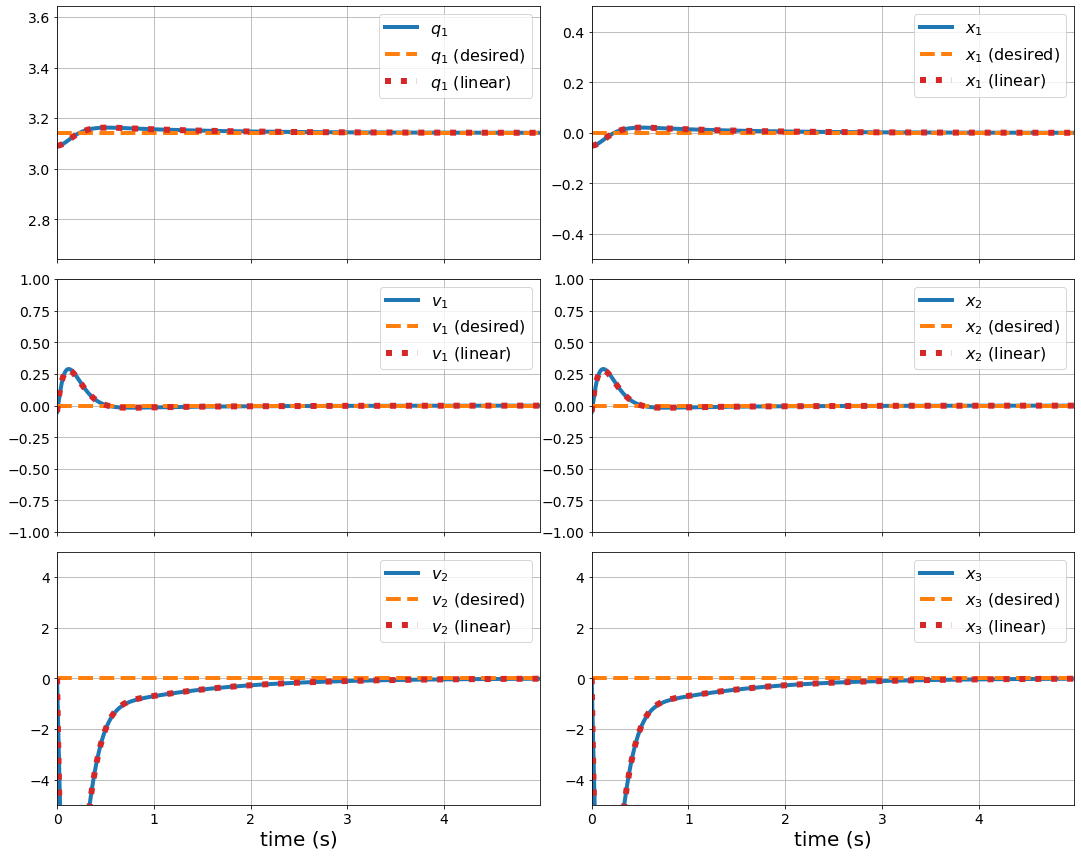

In [22]:
(q1e, v1e, v2e, taue) = (np.pi, 0., 0., 0.) # <-- EQUILIBRIUM POINT
K = np.array([[100., 50., 1.]]) # <-- GAIN MATRIX FOR LINEAR STATE FEEDBACK
(q1i, v1i, v2i) = (np.pi - 0.05, -0.05, 0.) # <-- INITIAL CONDITIONS

A, B = get_model(q1e, v1e, v2e, taue)
data = get_data(simulator, q1e, v1e, v2e, taue, K, q1i, v1i, v2i, max_time=5.0)
show_results(data, q1e, v1e, v2e, taue, A, B, K, q1i, v1i, v2i, show_pred=True)
# # show_x_symbolic(A, B, K)
# print('\nEIGENVALUES OF CLOSED-LOOP SYSTEM\n')
# print(f's = {linalg.eigvals(A - B @ K)}')